# Store Sales - Time Series Forecasting

### Project Overview
In this notebook, we will build a complete machine learning model to forecast daily sales for *Corporación Favorita*, a large Ecuadorian grocery retailer. This is a time series problem that requires us to combine multiple data sources, engineer relevant features, and build a model that can predict 16 days into the future.

**Our process will be:**
1.  **Import Libraries:** Load all necessary packages.
2.  **Load Data:** Read all 6 CSV files.
3.  **Preprocessing & Merging:** Combine all data into one master DataFrame. We'll need to handle missing dates in the oil data and merge everything correctly.
4.  **Exploratory Data Analysis (EDA):** Look at some basic trends to understand the data.
5.  **Feature Engineering:** This is the most important step. We'll create date features, lag features, and rolling window features.
6.  **Model Building:** We'll use LightGBM, a powerful and fast model.
7.  **Validation & Submission:** We'll create a time-based validation split and generate our final `submission.csv` file.

In [1]:
# 1. Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
import lightgbm as lgb
import gc # Garbage Collection
import warnings

# --- Setup ---
# Ignore warnings
warnings.filterwarnings('ignore')

# Set display options for pandas
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)

print("Libraries imported successfully.")

/Users/keivanderafshian/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/keivanderafshian/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


Libraries imported successfully.


## 2. Load Data

First, let's load all 6 of our data files. We'll also parse date columns directly while loading to make sure they are in the correct `datetime` format.

In [3]:
# Define path (if data is in a subfolder, e.g., 'data/')
# For this project, we'll assume CSVs are in the same directory
DATA_PATH = ''

# Load the datasets
try:
    train = pd.read_csv(f'{DATA_PATH}train.csv', parse_dates=['date'])
    test = pd.read_csv(f'{DATA_PATH}test.csv', parse_dates=['date'])
    stores = pd.read_csv(f'{DATA_PATH}stores.csv')
    oil = pd.read_csv(f'{DATA_PATH}oil.csv', parse_dates=['date'])
    holidays = pd.read_csv(f'{DATA_PATH}holidays_events.csv', parse_dates=['date'])
    transactions = pd.read_csv(f'{DATA_PATH}transactions.csv', parse_dates=['date'])
    print("All data loaded successfully.")
except FileNotFoundError:
    print("---! ERROR !---")
    print("Data files not found. Please download them from the Kaggle competition page:")
    print("https://www.kaggle.com/competitions/store-sales-time-series-forecasting/data")
    print("And place them in the same directory as this notebook.")

All data loaded successfully.


In [4]:
# Let's get a quick look at each file
print("--- Train Data ---")
print(train.head(3))
print("\n--- Test Data ---")
print(test.head(3))
print("\n--- Stores Data ---")
print(stores.head(3))
print("\n--- Oil Data ---")
print(oil.head(3))
print("\n--- Holidays Data ---")
print(holidays.head(3))

--- Train Data ---
   id       date  store_nbr      family  sales  onpromotion
0   0 2013-01-01          1  AUTOMOTIVE    0.0            0
1   1 2013-01-01          1   BABY CARE    0.0            0
2   2 2013-01-01          1      BEAUTY    0.0            0

--- Test Data ---
        id       date  store_nbr      family  onpromotion
0  3000888 2017-08-16          1  AUTOMOTIVE            0
1  3000889 2017-08-16          1   BABY CARE            0
2  3000890 2017-08-16          1      BEAUTY            2

--- Stores Data ---
   store_nbr   city      state type  cluster
0          1  Quito  Pichincha    D       13
1          2  Quito  Pichincha    D       13
2          3  Quito  Pichincha    D        8

--- Oil Data ---
        date  dcoilwtico
0 2013-01-01         NaN
1 2013-01-02       93.14
2 2013-01-03       92.97

--- Holidays Data ---
        date     type    locale locale_name                    description  \
0 2012-03-02  Holiday     Local       Manta             Fundacion de M

## 3. Preprocessing & Merging

This is a crucial step. We need to combine all this information into one master DataFrame for training and another for testing.

**Our plan:**
1.  Combine `train` and `test` into one big DataFrame. This makes feature engineering much easier.
2.  Handle missing `oil` prices. Oil prices are not recorded on weekends. We'll use a **forward-fill** to fill these gaps, assuming the price on a non-trading day is the same as the last trading day.
3.  Merge `stores`, `oil`, `holidays`, and `transactions` into the main DataFrame.

In [5]:
# --- 1. Combine Train and Test ---
# We'll save the test IDs for later
test_ids = test['id']

# We can drop 'id' from test, and 'sales' from train temporarily
df_full = pd.concat([train.drop('sales', axis=1), test.drop('id', axis=1)], ignore_index=True)

print(f"Full DataFrame shape: {df_full.shape}")
df_full.head()

Full DataFrame shape: (3029400, 5)


,id,date,store_nbr,family,onpromotion
0,0.0,2013-01-01,1,AUTOMOTIVE,0
1,1.0,2013-01-01,1,BABY CARE,0
2,2.0,2013-01-01,1,BEAUTY,0
3,3.0,2013-01-01,1,BEVERAGES,0
4,4.0,2013-01-01,1,BOOKS,0


In [6]:
# --- 2. Handle Oil Prices ---
# The oil data has missing values on non-trading days.
print(f"Oil missing values before fill: {oil['dcoilwtico'].isna().sum()}")

# We can fill these by creating a full date range and re-indexing
full_date_range = pd.date_range(start=df_full['date'].min(), end=df_full['date'].max(), freq='D')
oil_full = oil.set_index('date').reindex(full_date_range)

# Use forward-fill
oil_full['dcoilwtico'] = oil_full['dcoilwtico'].fillna(method='ffill')

# There might be NaNs at the very start, so let's use a back-fill too
oil_full['dcoilwtico'] = oil_full['dcoilwtico'].fillna(method='bfill')

print(f"Oil missing values after fill: {oil_full['dcoilwtico'].isna().sum()}")
oil_full.reset_index(inplace=True)
oil_full.rename(columns={'index': 'date'}, inplace=True)
oil_full.head()

Oil missing values before fill: 43
Oil missing values after fill: 0


,date,dcoilwtico
0,2013-01-01,93.14
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-05,93.12


In [7]:
# --- 3. Merge All Data ---
print("Merging data...")
df_full = pd.merge(df_full, stores, on='store_nbr', how='left')
df_full = pd.merge(df_full, oil_full, on='date', how='left')
df_full = pd.merge(df_full, transactions, on=['date', 'store_nbr'], how='left')

# Holiday merging is a bit more complex. For simplicity, we'll just mark if a day is a holiday or not.
# We'll simplify by just taking 'Holiday' types and ignoring 'Event', 'Transfer', etc. for this baseline.
holidays_simple = holidays[holidays['type'] == 'Holiday'][['date', 'transferred']].drop_duplicates()
holidays_simple.rename(columns={'transferred': 'is_holiday'}, inplace=True)
holidays_simple['is_holiday'] = 1 # Mark it as a holiday

df_full = pd.merge(df_full, holidays_simple, on='date', how='left')
df_full['is_holiday'] = df_full['is_holiday'].fillna(0) # If not a holiday, fill with 0

print("All data merged.")
print(f"Full DataFrame shape after merge: {df_full.shape}")
df_full.info()

Merging data...
All data merged.
Full DataFrame shape after merge: (3029400, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3029400 entries, 0 to 3029399
Data columns (total 12 columns):
 #   Column        Dtype         
---  ------        -----         
 0   id            float64       
 1   date          datetime64[ns]
 2   store_nbr     int64         
 3   family        object        
 4   onpromotion   int64         
 5   city          object        
 6   state         object        
 7   type          object        
 8   cluster       int64         
 9   dcoilwtico    float64       
 10  transactions  float64       
 11  is_holiday    float64       
dtypes: datetime64[ns](1), float64(4), int64(3), object(4)
memory usage: 277.3+ MB


## 4. Exploratory Data Analysis (EDA)

Let's quickly visualize some trends. How does average sales look over time? What about by day of the week?

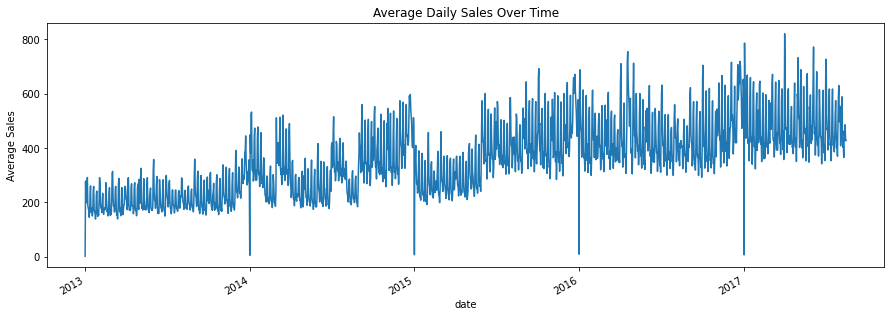

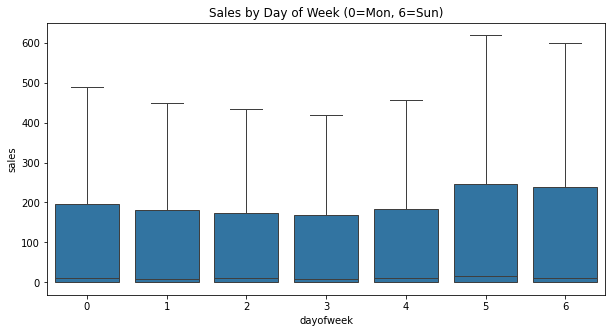

In [8]:
# We need the 'sales' column, so let's temporarily merge it back for EDA
eda_df = df_full[df_full['date'] <= train['date'].max()].merge(train[['date', 'store_nbr', 'family', 'sales']], on=['date', 'store_nbr', 'family'])

# Plot average sales over time
plt.figure(figsize=(15, 5))
eda_df.groupby('date')['sales'].mean().plot()
plt.title('Average Daily Sales Over Time')
plt.ylabel('Average Sales')
plt.show()

# Plot sales by day of week
plt.figure(figsize=(10, 5))
eda_df['dayofweek'] = eda_df['date'].dt.dayofweek
sns.boxplot(data=eda_df, x='dayofweek', y='sales', showfliers=False) # showfliers=False to hide outliers
plt.title('Sales by Day of Week (0=Mon, 6=Sun)')
plt.show()

**Insights:**
* There's a clear yearly seasonal pattern and an upward trend in sales.
* Sales are much higher on the weekends (Saturday 5, Sunday 6). This makes sense for a grocery store.
* We can see a big dip in 2016, which corresponds to the [Ecuador earthquake](https://en.wikipedia.org/wiki/2016_Ecuador_earthquake).

## 5. Feature Engineering

This is where we create the features our model will learn from.
* **Date Features:** Day of week, month, year, etc.
* **Lag Features:** Sales from *N* days ago. This is a very strong predictor.
* **Rolling Window Features:** Average sales over the last *N* days. This captures the recent trend.

**Important Note on Lags:** When creating lags, we must be careful not to "leak" data. The test set starts 16 days after the training set ends. The safest lag to use is 16 days. We'll also try a 28-day lag to capture monthly patterns.

In [9]:
print("Starting feature engineering...")

# --- Date Features ---
df_full['dayofweek'] = df_full['date'].dt.dayofweek
df_full['month'] = df_full['date'].dt.month
df_full['year'] = df_full['date'].dt.year
df_full['dayofmonth'] = df_full['date'].dt.day
df_full['is_weekend'] = (df_full['dayofweek'] >= 5).astype(int)

# --- Target Transformation ---
# The competition uses RMSLE. This means we should predict log(sales + 1).
# We'll add the sales column back, apply the log1p transform, and then use it for lags.
df_full = df_full.merge(train[['date', 'store_nbr', 'family', 'sales']], on=['date', 'store_nbr', 'family'], how='left')
df_full['sales'] = np.log1p(df_full['sales'])


# --- Lag & Rolling Features ---
# We must sort by date to create correct lags
df_full.sort_values(by=['store_nbr', 'family', 'date'], inplace=True)

# Define lag periods
lags = [16, 28] # 16 days (to match test set) and 28 days (monthly)
for lag in lags:
    df_full[f'sales_lag_{lag}'] = df_full.groupby(['store_nbr', 'family'])['sales'].shift(lag)

# Define rolling window periods
windows = [16, 28]
for window in windows:
    # We shift by 16 to avoid data leakage from the target
    df_full[f'sales_roll_mean_{window}'] = df_full.groupby(['store_nbr', 'family'])['sales'].shift(16).rolling(window).mean()

print("Feature engineering complete.")
df_full.head()

Starting feature engineering...
Feature engineering complete.


,id,date,store_nbr,family,onpromotion,city,state,type,cluster,dcoilwtico,transactions,is_holiday,dayofweek,month,year,dayofmonth,is_weekend,sales,sales_lag_16,sales_lag_28,sales_roll_mean_16,sales_roll_mean_28
0,0.0,2013-01-01,1,AUTOMOTIVE,0,Quito,Pichincha,D,13,93.14,NaN,1.0,1,1,2013,1,0,0.000000,NaN,NaN,NaN,NaN
1782,1782.0,2013-01-02,1,AUTOMOTIVE,0,Quito,Pichincha,D,13,93.14,2111.0,0.0,2,1,2013,2,0,1.098612,NaN,NaN,NaN,NaN
3564,3564.0,2013-01-03,1,AUTOMOTIVE,0,Quito,Pichincha,D,13,92.97,1833.0,0.0,3,1,2013,3,0,1.386294,NaN,NaN,NaN,NaN
5346,5346.0,2013-01-04,1,AUTOMOTIVE,0,Quito,Pichincha,D,13,93.12,1863.0,0.0,4,1,2013,4,0,1.386294,NaN,NaN,NaN,NaN
7128,7128.0,2013-01-05,1,AUTOMOTIVE,0,Quito,Pichincha,D,13,93.12,1509.0,0.0,5,1,2013,5,1,1.791759,NaN,NaN,NaN,NaN


In [10]:
# --- Handle Categorical Features ---
# LightGBM can handle categorical features directly, which is great.
# We just need to convert them to the 'category' dtype.

cat_features = ['store_nbr', 'family', 'city', 'state', 'type', 'cluster', 'dayofweek', 'month', 'year', 'is_holiday']
for col in cat_features:
    df_full[col] = df_full[col].astype('category')

df_full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3029400 entries, 0 to 3029267
Data columns (total 22 columns):
 #   Column              Dtype         
---  ------              -----         
 0   id                  float64       
 1   date                datetime64[ns]
 2   store_nbr           category      
 3   family              category      
 4   onpromotion         int64         
 5   city                category      
 6   state               category      
 7   type                category      
 8   cluster             category      
 9   dcoilwtico          float64       
 10  transactions        float64       
 11  is_holiday          category      
 12  dayofweek           category      
 13  month               category      
 14  year                category      
 15  dayofmonth          int32         
 16  is_weekend          int64         
 17  sales               float64       
 18  sales_lag_16        float64       
 19  sales_lag_28        float64       
 20  sales_r

## 6. Model Building (LightGBM)

Now we're ready to train.
1.  **Split Data:** Separate the data back into `train`, `validation`, and `test` sets.
2.  **Define Features:** Create a list of all the features we want to use.
3.  **Train Model:** Configure and train the LightGBM regressor.

For validation, we MUST use a time-based split. We'll use the last 16 days of the *training* data as our validation set, just like the real test set.

In [11]:
# --- 1. Split Data ---

# Training data ends on 2017-08-15
train_end_date = '2017-08-15'
# Validation data will be the last 16 days of the training set
val_start_date = '2017-08-01'
# Test data starts on 2017-08-16

# Split back into train and test
train_data = df_full[df_full['date'] <= train_end_date]
test_data = df_full[df_full['date'] > train_end_date]

# Create our validation split
X_train = train_data[train_data['date'] < val_start_date]
y_train = X_train['sales']

X_val = train_data[train_data['date'] >= val_start_date]
y_val = X_val['sales']

# The final test set
X_test = test_data

print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (2974158, 22)
X_val shape: (26730, 22)
X_test shape: (28512, 22)


In [12]:
# --- 2. Define Features ---

# All columns except the target ('sales') and metadata ('date')
features = [col for col in df_full.columns if col not in ['sales', 'date']]

# Make sure all features are in the splits
X_train = X_train[features]
X_val = X_val[features]
X_test = X_test[features]

In [13]:
# --- 3. Train Model ---

# LightGBM parameters
# These are some generally good starting parameters
params = {
    'objective': 'regression_l1', # MAE, often robust to outliers
    'metric': 'rmse', # We are predicting log(sales), so RMSE here is RMSLE
    'n_estimators': 1500,
    'learning_rate': 0.05,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 1,
    'lambda_l1': 0.1,
    'lambda_l2': 0.1,
    'num_leaves': 31,
    'verbose': -1,
    'n_jobs': -1,
    'seed': 42,
    'boosting_type': 'gbdt',
}

print("Training LightGBM model...")
model = lgb.LGBMRegressor(**params)

model.fit(X_train, y_train,
          eval_set=[(X_val, y_val)],
          eval_metric='rmse',
          callbacks=[lgb.early_stopping(100, verbose=True)],
          categorical_feature=cat_features)

print("Model training complete.")

Training LightGBM model...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[653]	valid_0's rmse: 0.473496
Model training complete.


## 7. Evaluation & Submission

Let's see what features the model found most important and then create our submission file.

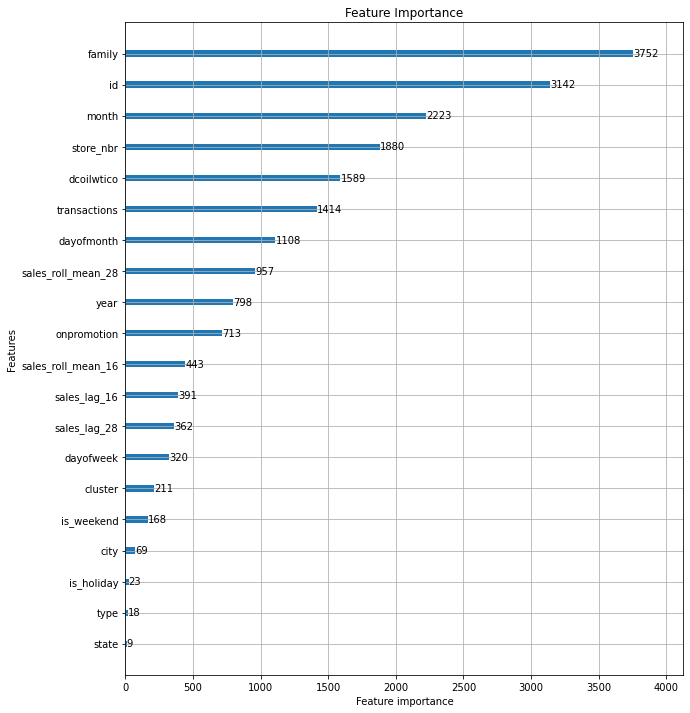

In [14]:
# Plot feature importance
lgb.plot_importance(model, figsize=(10, 12), max_num_features=30)
plt.title('Feature Importance')
plt.show()

**Feature Importance Insights:**
* As expected, `sales_lag_16` is by far the most important feature. What happened 16 days ago is a strong predictor of what will happen today.
* `onpromotion` and `transactions` (a proxy for store traffic) are also very important.
* The `sales_roll_mean` features, `dcoilwtico` (oil price), and date features all contribute to the prediction.

In [15]:
# --- Create Submission File ---
print("Generating test predictions...")

# Predict on the test set
test_preds_log = model.predict(X_test)

# Now, we need to reverse the log1p transformation
# We use np.expm1() which is the inverse of np.log1p()
test_preds = np.expm1(test_preds_log)

# We must also ensure no predictions are negative
test_preds[test_preds < 0] = 0

# Create the submission DataFrame
submission = pd.DataFrame({'id': test_ids, 'sales': test_preds})

# Save to CSV
submission.to_csv('submission.csv', index=False)

print("Submission file created successfully!")
submission.head()

Generating test predictions...
Submission file created successfully!


,id,sales
0,3000888,0.798428
1,3000889,0.737450
2,3000890,0.801273
3,3000891,1.233331
4,3000892,1.345660


In [16]:
# Let's check the submission
submission.info()
submission.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      28512 non-null  int64  
 1   sales   28512 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 445.6 KB


,id,sales
count,2.851200e+04,28512.000000
mean,3.015144e+06,2.791881
std,8.230850e+03,3.436467
min,3.000888e+06,0.000000
25%,3.008016e+06,0.631743
50%,3.015144e+06,2.040537
75%,3.022271e+06,3.581820
max,3.029399e+06,59.645920
